In [1]:
%pylab inline


import numpy as np
import copy
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from scipy.integrate import solve_ivp
import Constant_JGRpaper as cst

# 0D model
from zerodim_moulin_model import simple_sim

# 1D model
from onedim_channel_model import one_dim_sim


secinday = 24*3600

Populating the interactive namespace from numpy and matplotlib


# Figure S6

Comparison between the 0D single-conduit model used in the paper and a similar 1D single-conduit model, where each node along the conduit has a different effective pressure and cross-sectional area, using an idealized square-root glacie

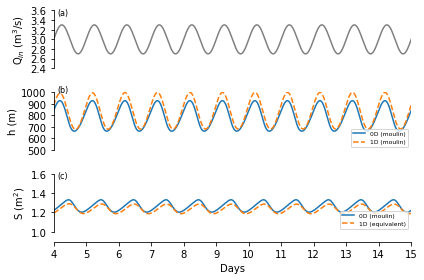

In [8]:
#Glacier parameters
moulin_radii = 1. #m (based out of the highest radius when running moush for JEME)
ice_thickness = 1000 #m
initial_head = 900 #m
initial_subglacial_area = 1 #m
channel_length = 30e3 #m 

Qin_mean = 3
dQ = 0.3

#%% Simulation with Matt new 1D subglacial channel model

h_1d_moulin = []
h_1d_margin = []
s_1d_moulin = []
s_1d_margin = []
s_1d_equiv = []
t_1d = []

params = {'R_func': 'sin', 
          'R_mean': Qin_mean, 
          'R_min': Qin_mean - dQ, 
          'A_R': np.pi * moulin_radii**2, 
          'L': channel_length, 
          'h0_init': initial_head,
          "S0": initial_subglacial_area,  # Conduit area in m^2
          "dt": 500,  # time in seconds
          }
sim = one_dim_sim(params = params)
nsteps = 200000
for i in np.arange(nsteps):
     sim.run_one_step(dt=50)
     h_1d_moulin.append(sim.h_node[0])
     h_1d_margin.append(sim.h_node[-2])
     s_1d_moulin.append(sim.S[0])
     s_1d_margin.append(sim.S[-2])
     s_1d_equiv.append((len(sim.S)/sum(sim.S**(-5/2)))**(2/5))
     t_1d.append(sim.t)
     
t_1d = np.array(t_1d)
     
#%% Simulation with 0D
t0= 0 #starting time
tf= 30 *secinday #(s) indicate number of days until solver stops

def dy_dt(t,y):
    # print(f'y: {y}')
    h = y[0] #(–) S*: Non dimentionalized channel cross-section area
    S = y[1] #(–) h*: Non dimentionalized moulin head
    A_R = np.pi*moulin_radii**2
    L=channel_length
    H=ice_thickness
    Pi = cst.rhoi*cst.g*H 
    
    #R(t)
    Rt =   dQ * np.sin(2.*np.pi*t/secinday) + Qin_mean
    #Head partial differential equation
    dhdt = 1/A_R * ( Rt - cst.C3*S**(5/4)*np.sqrt((cst.rhow*cst.g*h)/L) )
    #Channel cross section area partial differential equation
    dSdt = cst.C1 * cst.C3 * S**(5/4) * ((cst.rhow*cst.g*h)/L)**(3/2) - cst.C2 * ( Pi - cst.rhow*cst.g*h )**cst.n * S
    return [dhdt, dSdt]

sol = solve_ivp(dy_dt,(t0, tf),(initial_head,initial_subglacial_area),method = 'LSODA',max_step = 10*60)
h_0d = sol.y[0]
S_0d = sol.y[1]
t_0d = sol.t



#%% Plot head for all simulations
#xlim = [195,200]
#xlim = [180,250]
Qin = dQ * np.sin(2.*np.pi*t_0d/secinday) + Qin_mean
Qin_1d = dQ * np.sin(2.*np.pi*t_1d/secinday) + Qin_mean

fig,ax = plt.subplots(3,1)#, sharex=True)
#plt.figure()

#Plot Qin
ax[0].plot(t_0d/secinday,Qin, color='grey')
ax[0].set_ylabel('Q$_{in}$ (m$^3$/s)')
ax[0].tick_params(labelbottom=False)
#Oax[0].set_xticks([])
ax[0].set_ylim([2.4,3.6])
ax[0].set_yticks([2.4,2.6,2.8,3,3.2,3.4,3.6])
ax[0].set_xlim([4,15])
ax[0].set_xticks([])

#Plot head
ax[1].plot(t_0d/secinday,h_0d, linestyle='-',label='0D (moulin)')
ax[1].plot((t_1d-300)/secinday,h_1d_moulin,linestyle='--',label='1D (moulin)')
ax[1].legend(loc=4, prop={'size': 6})#(loc=4, prop={'size': 6}, bbox_to_anchor=(0.3,1))
ax[1].set_ylim([500,1000])
ax[1].set_yticks([500,600,700,800,900,1000])
ax[1].set_ylabel('h (m)')
ax[1].tick_params(labelbottom=False)
ax[1].set_xlim([4,15])
ax[1].set_xticks([])

#Plot subglacial channel
ax[2].plot(t_0d/secinday, S_0d,linestyle='-',label='0D (moulin)')
#ax[2].plot(t_1d/secinday,s_1d_moulin,linestyle='--',label='1D (moulin)')
ax[2].plot(t_1d/secinday,s_1d_equiv,linestyle='--',label='1D (equivalent)')
ax[2].legend(loc=4, prop={'size': 6})#(loc=4, prop={'size': 6}, bbox_to_anchor=(0.3,1))
ax[2].set_ylim([1,1.6])
ax[2].set_xlim([4,15])
ax[2].set_yticks([1,1.2,1.4,1.6])
ax[2].set_xticks([4,5,6,7,8,9,10,11,12,13,14,15])
ax[2].set_ylabel('S (m$^2$)')
ax[2].set_xlabel('Days')

ax[0].text(4.1,3.5,'(a)',fontsize=8)
ax[1].text(4.1,1000,'(b)',fontsize=8)
ax[2].text(4.1,1.55,'(c)',fontsize=8)

sns.despine(ax=ax[0],bottom=True)#trim=True)
sns.despine(ax=ax[1],bottom=True)
sns.despine(ax=ax[2],bottom=False, offset=(0,10))

plt.tight_layout()

plt.savefig('compare_0D1D.pdf')
plt.savefig('compare_0D1D.png')

In [47]:
amplitude_0d = max(h_0d[3800:-1]) - min(h_0d[3800:-1])
amplitude_1d = max(h_1d_moulin[195000:-1]) - min(h_1d_moulin[195000:-1])

print(amplitude_0d)
print(amplitude_1d)

print('percent A1D=',np.round(100*(amplitude_0d-amplitude_1d)/amplitude_0d,2))
print('percent H',np.round(100*(amplitude_0d-amplitude_1d)/1000,2))
#plot(h_1d_moulin[195000:-1])
#plot(h_0d[3800:-1])

263.20282338806317
315.5253209639126
percent A1D= -19.88
percent H -5.23


# Figure S7

C:\Users\truc3007\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\truc3007\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\truc3007\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-o

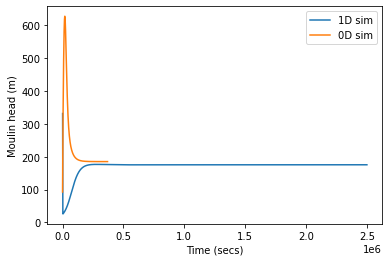

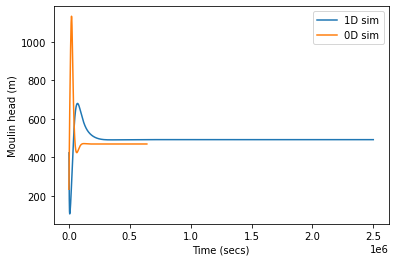

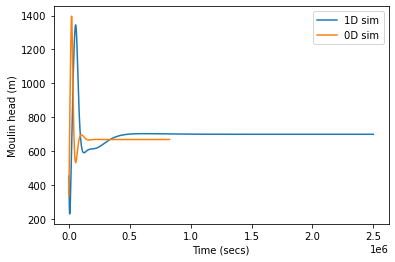

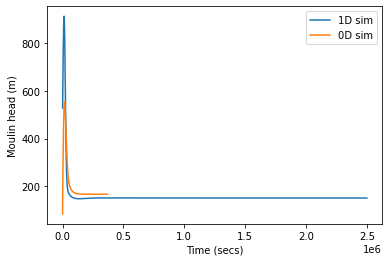

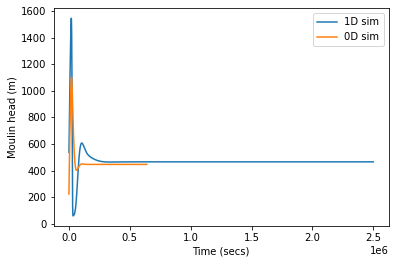

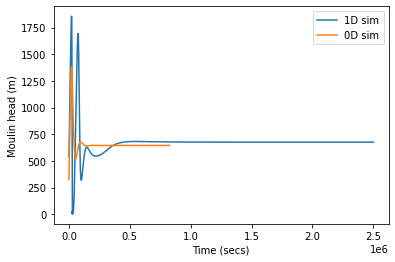

In [4]:
Q_list = [1., 10.]
L_list = [5000.,15000.,25000.]
Q_rec = []
L_rec = []
A_R_Ref = 10.
Q_ref = 1.
nsteps = 5000
S_equiv = []
S_simp = []
dt_1D = 500.
for Q in Q_list:
    for L in L_list:
        Q_rec.append(Q)
        L_rec.append(L)
        A_R = A_R_Ref * Q / Q_ref 
        params = {'R_mean': Q, 'L': L, 'A_R':A_R}
        # Run 1D sim
        sim1D = one_dim_sim(params=params)
        moulin_h = []
        t = []
        for i in np.arange(nsteps):
            sim1D.run_one_step(dt=dt_1D)
            moulin_h.append(sim1D.h_node[0])
            t.append(sim1D.t)
        # Plot head time series to make sure we reach equilibrium
        figure()
        plot(t, moulin_h)
        xlabel('Time (secs)')
        ylabel('Moulin head (m)')
        S_equiv.append(sim1D.calc_S_equiv())
        # Run corresponding 0D sim
        params['Z_i'] = sim1D.Z[0]
        simp = simple_sim(params=params)
        simp.run(run_params={'t_f': 100})
        plot(simp.t, simp.h)
        legend(['1D sim', '0D sim'])
        S_simp.append(simp.S[-1])

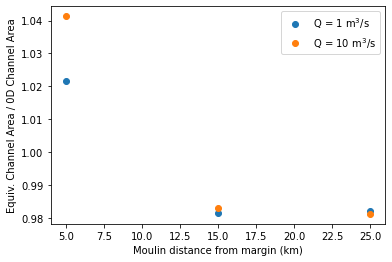

In [13]:
L_rec = array(L_rec)
Q_rec = array(Q_rec)
S_ratio = array(S_equiv)/array(S_simp)

plot(L_rec[Q_rec==1]/1000, S_ratio[Q_rec==1], 'o')
plot(L_rec[Q_rec==10]/1000, S_ratio[Q_rec==10], 'o')
legend(['Q = 1 m$^3$/s', 'Q = 10 m$^3$/s'])
xlabel('Moulin distance from margin (km)')
ylabel('Equiv. Channel Area / 0D Channel Area')
savefig('Equivalent-cross-sections.png')
savefig('Equivalent-cross-sections.pdf')

